In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import pandas as pd
from collections import OrderedDict
%matplotlib inline

In [2]:
def system(t, x, C, A, gl, El, gsyn, Esyn, w=1):
    V = x[0]
    P = x[1:]
    Isyn = w * gsyn * x[-1] * (Esyn - V)
    xdot = np.zeros(x.shape)
    xdot[0] = (gl * (El - V) + Isyn) / C
    xdot[1:] = A @ P
    return xdot

In [3]:
def integrate_system(A, t_span, P0, axes=None):
    sol = solve_ivp(lambda t,P: A @ P, t_span, P0, rtol=1e-8, atol=1e-10)
    if axes is not None:
        col = 'kcbgr'
        state_names = ['Ru', 'Rb', 'Rc', 'Ro']
        for i,ax in enumerate(axes):
            ax.plot(sol['t'], sol['y'][i], lw=1, color=col[i])
            ax.set_ylabel(state_names[i])
    return sol

In [4]:
def extract_time_constant(kon, koff, CC, CO, Beta, Alpha, do_plot=False):
    A = lambda C: np.array([
        [- kon * C,        koff,           0,     0], \
        [  kon * C, - koff - CC,          CO,     0], \
        [        0,          CC, - Beta - CO,  Alpha], \
        [        0,           0,        Beta, -Alpha] \
    ])

    if do_plot:
        fig,ax = plt.subplots(4, 1, figsize=(5,13))
    else:
        ax = None

    t_tran = 0.3
    dur = 100
    sol = integrate_system(A(1), [0,t_tran], [1,0,0,0], ax)
    sol = integrate_system(A(0), [t_tran,t_tran+dur], sol['y'][:,-1], ax)
    func = lambda t,a,tau: a * np.exp(-t / tau)
    x = sol['t'] - t_tran
    tau = []
    for i in range(sol['y'].shape[0]):
        if i == 0:
            y = 1 - sol['y'][i]
        else:
            y = sol['y'][i]
        popt,_ = curve_fit(func, x, y, p0=(np.max(y), 5))
        tau.append(popt[1])
    return np.array(tau)

In [5]:
cm = 1          # [uF/cm2]
El = -70.       # [mV]
GL = 0.0001     # [S/cm2]
Esyn = 0.       # [mV]
gsynbar = 0.001 # [uS]
gsyn = gsynbar * 1e-3  # [mS]

# the desired input resistance
Rm = 100        # [MOhm]

area = 1e-6 / (Rm * GL)
C = cm * area # [uF]
tau = cm / GL * 1e-3 # [ms]
gl = GL * area * 1e3 # [mS]

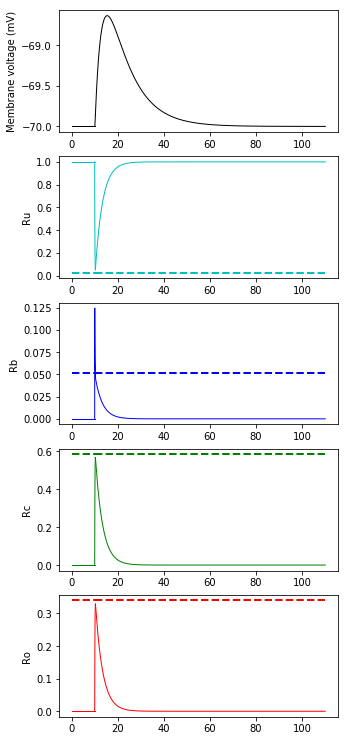

In [10]:
kon = 12.88
koff = 6.47
CC = 69.97
CO = 6.16
Beta = 100.63
Alpha = 173.04

A = lambda C: np.array([
    [- kon * C,        koff,           0,     0], \
    [  kon * C, - koff - CC,          CO,     0], \
    [        0,          CC, - Beta - CO,  Alpha], \
    [        0,           0,        Beta, -Alpha] \
])

w = 3

t_tran = 10
dur = 0.3
t_end = t_tran + 100

x0 = np.array([El, 1, 0, 0, 0])
sys_C0 = lambda t,x: system(t, x, C, A(0), gl, El, gsyn, Esyn, w)
sys_Cmax = lambda t,x: system(t, x, C, A(1), gl, El, gsyn, Esyn, w)

sol = [solve_ivp(sys_C0, [0,t_tran], x0, rtol=1e-8, atol=1e-10)]
sol.append( solve_ivp(sys_Cmax, [t_tran, t_tran+dur], sol[-1]['y'][:,-1], rtol=1e-8, atol=1e-10) )
sol.append( solve_ivp(sys_C0, [t_tran+dur, t_end], sol[-1]['y'][:,-1], rtol=1e-8, atol=1e-10) )

conc = 1
den = koff * CO * Alpha + conc * kon * CO * Alpha + conc * kon * CC * Alpha + conc * kon * CC * Beta
num = np.array([koff * CO * Alpha, conc * kon * CO * Alpha, conc * kon * CC * Alpha, conc * kon * CC * Beta])

state_names = ['Ru', 'Rb', 'Rc', 'Ro']
n_states = len(state_names)
col = 'kcbgr'
fig,ax = plt.subplots(n_states+1,1,figsize=(5,13))
for s in sol:
    ax[0].plot(s['t'], s['y'][0], lw=1, color=col[0])
    ax[0].set_ylabel('Membrane voltage (mV)')
    for i in range(1, n_states+1):
        ax[i].plot(s['t'][[0,-1]], num[i-1]/den + np.zeros(2), '--', lw=2, color=col[i])
        ax[i].plot(s['t'], s['y'][i], lw=1, color=col[i])
        ax[i].set_ylabel(state_names[i-1])
        #ax[i].set_xlim([t_tran-0.1,t_tran+2*dur])

In [18]:
AMPA_defaults = OrderedDict()
GABAA_defaults = OrderedDict()
NMDA_defaults = OrderedDict()

AMPA_defaults ['kon'] = 12.88
NMDA_defaults ['kon'] = 86.89
GABAA_defaults['kon'] = 5.397

AMPA_defaults ['koff'] = 6.47
NMDA_defaults ['koff'] = 0.69
GABAA_defaults['koff'] = 4.433

AMPA_defaults ['CC'] = 69.97
NMDA_defaults ['CC'] = 9.64
GABAA_defaults['CC'] = 20.945

AMPA_defaults ['CO'] = 6.16
NMDA_defaults ['CO'] = 2.60
GABAA_defaults['CO'] = 1.233

AMPA_defaults ['Beta'] = 100.63
NMDA_defaults ['Beta'] = 0.68
GABAA_defaults['Beta'] = 283.09

AMPA_defaults ['Alpha'] = 173.04
NMDA_defaults ['Alpha'] = 0.079
GABAA_defaults['Alpha'] = 254.52


Time constants = [3.177, 3.128, 3.179, 3.181] ms.


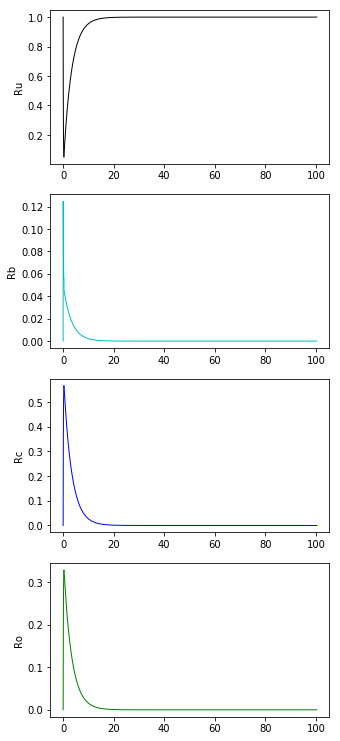

In [15]:
pars = AMPA_defaults.copy()
p = list(pars.values())
tau = extract_time_constant(*p, do_plot=True)
print('Time constants = [{:.3f}, {:.3f}, {:.3f}, {:.3f}] ms.'.format(*tau))

Time constants = [62.025, 1.624, 1.908, 114.962] ms.


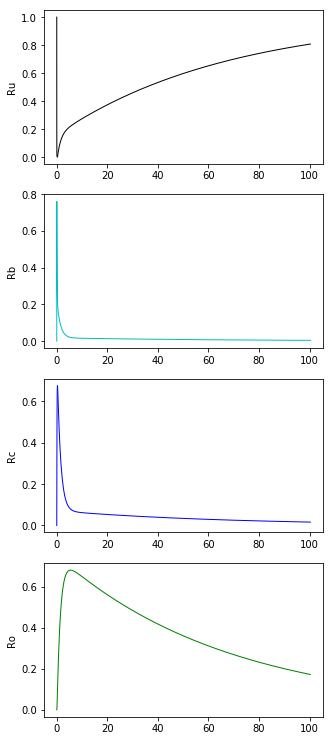

In [16]:
pars = NMDA_defaults.copy()
p = list(pars.values())
tau = extract_time_constant(*p, do_plot=True)
print('Time constants = [{:.3f}, {:.3f}, {:.3f}, {:.3f}] ms.'.format(*tau))

Time constants = [9.991, 8.625, 10.021, 10.024] ms.


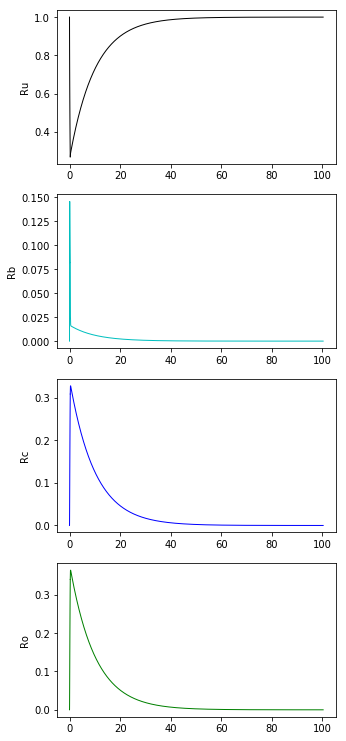

In [17]:
pars = GABAA_defaults.copy()
p = list(pars.values())
tau = extract_time_constant(*p, do_plot=True)
print('Time constants = [{:.3f}, {:.3f}, {:.3f}, {:.3f}] ms.'.format(*tau))

In [ ]:
defaults = AMPA_defaults.copy()
defaults['tau'] = 0
df = pd.DataFrame(data={k: [] for k in defaults})
defaults.pop('tau')

N = 10
for i,key in enumerate(defaults):
    p = list(defaults.values())
    values = np.logspace(np.log10(defaults[key])-1, np.log10(defaults[key])+1, N)
    for val in values:
        p[i] = val
        x = {k: p[j] for j,k in enumerate(defaults)}
        x['tau'] = extract_time_constant(*p, do_plot=False)
        df = pd.concat((df, pd.DataFrame(data=x, index=[0])), ignore_index=True)
df